In [13]:
# Imports

%matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
import scipy.signal as sc
import scipy.io.wavfile as sc_wav
import csv 
import pandas as pd


In [14]:


def compareToPitches(pitch, pitchtable):
    found = 0

    if pitch <= pitchtable[0]:
        exactpitch = pitchtable[0]
        found = 1


    if found==0:
        if pitch > pitchtable[len(pitchtable)-1]:
            exactpitch = pitchtable[len(pitchtable)-1]
            found = 1
        
    i = 1
    while found==0:
        if pitch > pitchtable[i] and pitch <= pitchtable[i+1]:
            exactpitch = pitchtable[i+1]
            found=1
        i = i+1

    return exactpitch




In [15]:
def auto_corr(x,fm):

    T=1/fm 
    #por que no me andan los commits lpm
    pmin=50
    pmax=400

    Tmin=1/pmax
    Tmax=1/pmin

    nmin=int(math.floor(Tmin/T))
    nmax=int(math.ceil(Tmax/T))

    x_cor=np.correlate(x,x,mode='full')
    x_cor=x_cor[len(x):len(x_cor)]

    i=np.argmax(x_cor[nmin:nmax])

    npitch=i+nmin
    Tpitch=npitch*T

    Fpitch=1/Tpitch

    return Fpitch



5722
5722


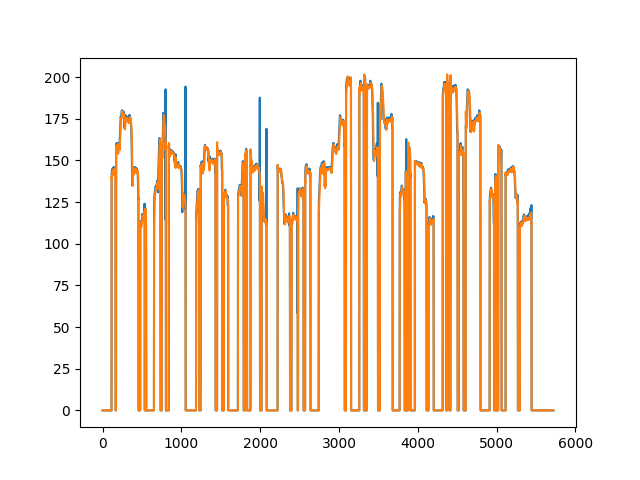

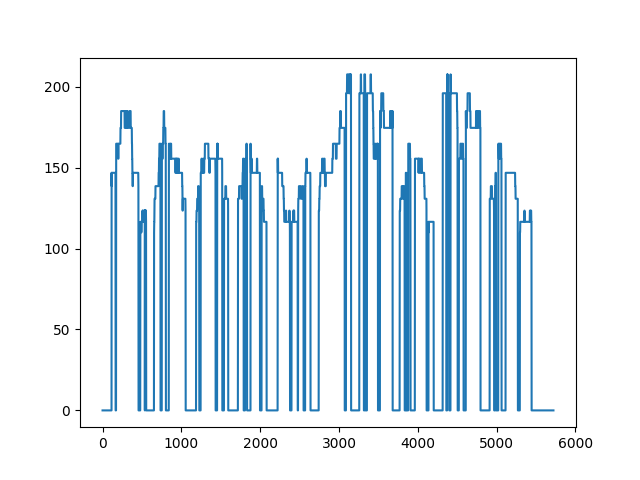

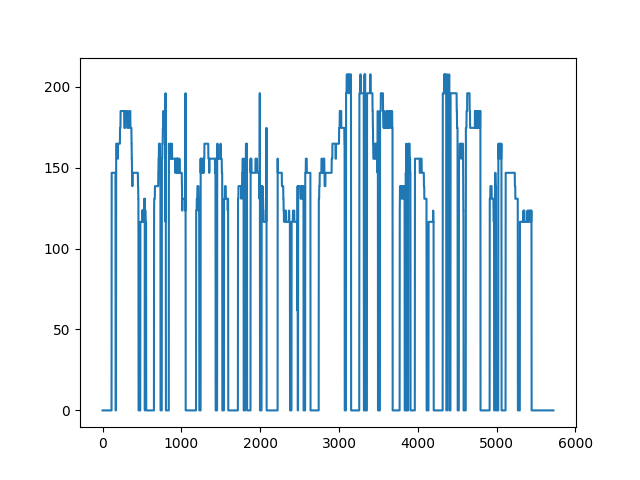

In [16]:
rate, signal = sc_wav.read('dataset_proyecto/vocadito_1.wav')

ref_aux=pd.read_csv('dataset_proyecto/vocadito_1_f0.csv',names=['f0','t'])

# list with each item representing a column
ref = []
for col in ref_aux:
    # convert pandas series to list
    col_ref = ref_aux[col].tolist()
    # append column list to ls
    ref.append(col_ref)
# print the created list

ref_f0=ref[1]
ref_t=ref[0]


tvent = 0.032
tstep = 0.005804988662131519


nvent = int(tvent*rate)
nstep = int(tstep*rate)

nframes=len(ref[0])
#nframes=int((len(signal)-nvent-nvent/2-nstep)/nstep)

cant_vent = int((len(signal)/nvent))
vent = np.hamming(nvent)

ini=nvent//2
p_corr = np.zeros(nframes)
print(nframes)
print(len(p_corr))
for i in range(nframes):
    if ref_f0[i]>0:
        p_corr[i] = auto_corr(signal[ini:ini + nvent]*vent,rate)
    
    ini = ini + nstep


treshold = 200
for i in range(nframes):
    
   if p_corr[i]>=treshold:
       p_corr[i]=p_corr[i-1]
#for i in range(nframes-1):  
# if  abs(p_corr[i+1]-p_corr[i]) or abs(p_corr[i-1]-p_corr[i]) >=treshold:    
#        if p_corr[i-1]!=0 and p_corr[i+1]!=0:
#            p_corr[i]=p_corr[i-1]/2 + p_corr[i+1]/2
#        else:
#            p_corr[i]=0


plt.close('all')
plt.plot(p_corr)
plt.plot(ref_f0)
plt.show()

pitch_table=[0,16.352,17.324,18.354,19.445,20.602,21.827,23.125,24.500,25.957,27.500,29.135,30.868,32.703,34.648,36.708,38.891,41.203,43.654,46.249,48.999,51.913,55.000,58.270,61.735,65.406,69.296,73.416,77.782,82.407,87.307,92.499,97.999,103.830,110.000,116.540,123.470,130.800,138.590,146.830,155.560,164.810,174.610,185.000,196.000,207.650,220.000,233.080,246.940,261.630,277.180,293.660,311.130,329.630,349.230,369.990,392.000,415.300,440.000,466.160,493.880,523.250,554.370,587.330,622.250,659.260,698.460,739.990,783.990,830.610,880.000,932.330,987.770,1046.500,1108.700,1174.700,1244.500,1318.500,1396.900,1480.000,1568.000,1661.200,1760.000,1864.700,1975.500,2093.000,2217.500,2349.300,2489.000,2637.000,2793.800,2960.000,3136.000,3322.400,3520.000,3729.300,3951.100,4186.000,4434.900,4698.600,4978.000,5274.000,5587.700,5919.900,6271.900,6644.900,7040.000,7458.600,7902.100,8372.000,8869.800,9397.300,9956.100,10548.100,11175.300,11839.800,12543.900,13289.800,14080.000,14917.200,15804.300,16744.000,17739.700,18794.500,19912.100,21096.200,22350.600]
corrected_pitch=np.zeros(len(ref_f0))
for i in range(len(ref_f0)-1):
    corrected_pitch[i]=compareToPitches(ref_f0[i], pitch_table)

plt.figure()
plt.plot(corrected_pitch)
plt.show()

corrected_pitch=np.zeros(len(p_corr))
for i in range(len(p_corr)-1):
    corrected_pitch[i]=compareToPitches(p_corr[i], pitch_table)


plt.figure()
plt.plot(corrected_pitch)
plt.show()


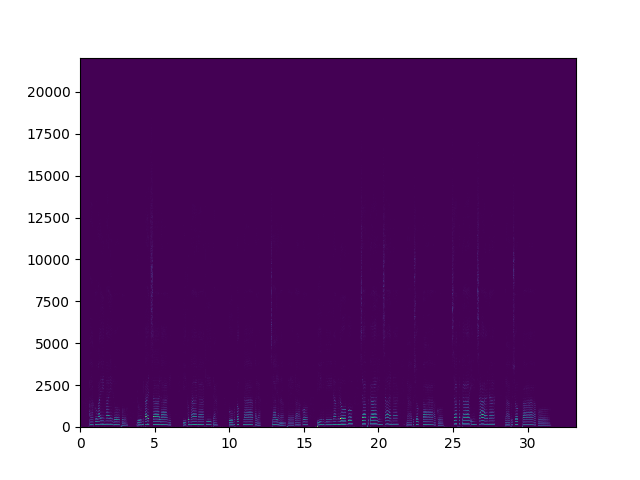

C:\Users\daian\AppData\Local\Temp\ipykernel_19088\3997291930.py:9: RuntimeWarning: invalid value encountered in true_divide
  ratio=corrected_pitch/p_corr
C:\Users\daian\AppData\Local\Temp\ipykernel_19088\3997291930.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  S_corrected[j,k] = z[y,k]


[1. 1. 1. ... 1. 1. 1.]


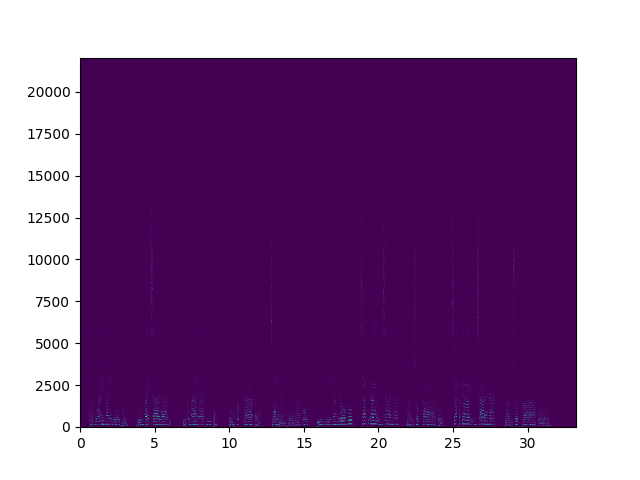

5722
5722


C:\Users\daian\AppData\Local\Temp\ipykernel_19088\3997291930.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


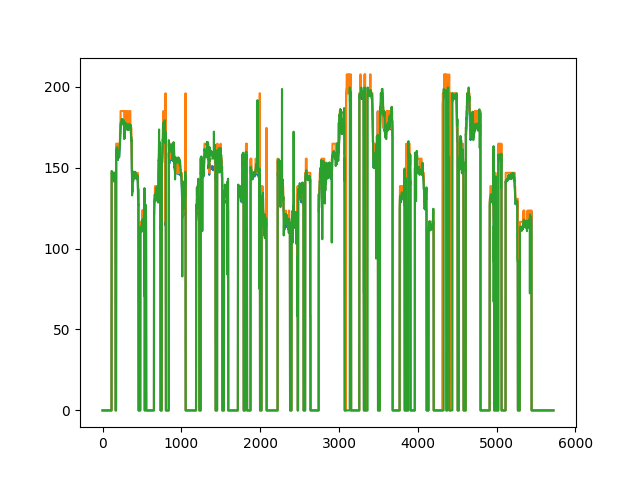

In [22]:
f,t,z = sc.stft(signal,rate,vent,nperseg=nvent,noverlap=nvent**0.75)

plt.figure()
plt.pcolormesh(t,f,abs(z),vmin=0)
plt.show()

pcorr2=p_corr

ratio=corrected_pitch/p_corr
ratio[np.isnan(ratio)]=1
S_corrected=np.zeros((len(f),len(t)))
print(ratio)
for k in range(len(t)):
    for j in range(len(f)):
        y = round(j/ratio[k])
          
        #Prevents negative indices
        if y < 1:
            y = 1
          
        #Non-constant frequency scaling
        if y <= len(f):
            S_corrected[j,k] = z[y,k]
          
        
plt.figure()
plt.pcolormesh(t,f,abs(S_corrected),vmin=0)
plt.show()


t,senal=sc.istft(S_corrected,rate,vent,nperseg=nvent,noverlap=nvent**0.75)

ini=nvent//2
pcorr2 = np.zeros(nframes)
print(nframes)
print(len(pcorr2))
for i in range(nframes):
    if ref_f0[i]>0:
        pcorr2[i] = auto_corr(senal[ini:ini + nvent]*vent,rate)
    
    ini = ini + nstep


treshold = 200
for i in range(nframes):
    
   if pcorr2[i]>=treshold:
       pcorr2[i]=pcorr2[i-1]

plt.figure()
plt.plot(p_corr)
plt.plot(corrected_pitch)
plt.plot(pcorr2)
plt.show()

sc_wav.write('test_01.wav',rate,senal.astype(np.int16))
sc_wav.write('test_02.wav',rate,signal.astype(np.int16))
rate2, senal2 = sc_wav.read('test_01.wav')


